# **Modern convnet architecture patterns**

### Residual connections

The residual connection acts as an information shortcut around destructive or noisy blocks (such as blocks that contain relu activations or dropout layers), enabling error gradient information from early layers to propagate noiselessly through a deep network.

**Residual block where the number of filters changes**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
# set residual layer equivalent to the first layer
residual = x
# first layer increases the number of output filers from 32 to 64
# padding="same" to avoid downsampling due to padding
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# The residual only had 32 filters, so use a 1 × 1 Conv2D to project it to the correct shape.
residual = layers.Conv2D(64, 1)(residual)
# Now the block output and the residual have the same shape and can be added
x = layers.add([x, residual])

In [ ]:
residual.shape, x.shape

(TensorShape([None, 30, 30, 64]), TensorShape([None, 30, 30, 64]))

**Case where target block includes a max pooling layer**

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
# the block of two layers around which creates a residual connection: it includes a 2 × 2 max pooling layer
# padding="same" to avoid downsampling due to padding
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)

# use strides=2 in the residual projection to match the downsampling created by the max pooling layer
residual = layers.Conv2D(64, 1, strides=2)(residual)
# Now the block output and the residual have the same shape and can be added
x = layers.add([x, residual])

In [ ]:
residual.shape, x.shape

(TensorShape([None, 15, 15, 64]), TensorShape([None, 15, 15, 64]))

Create function to handle the option to add max pooling

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

# function to apply a convolutional block with a residual connection, with an option to add max pooling
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)

    # If we use max pooling, we add a strided convolution to project the residual to the expected shape
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    # If we don’t use max pooling, we only project the residual if the number of channels has changed.
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
# The last block doesn’t need a max in each block pooling layer,
# since we will apply global average pooling right after it
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 32, 32, 3)            0         ['input_9[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 32, 32, 32)           896       ['rescaling_1[0][0]']         
                                                                                                  
 conv2d_31 (Conv2D)          (None, 32, 32, 32)           9248      ['conv2d_30[0][0]']           
                                                                                            

### Batch normalization

The most common form of data normalization is that it makes the assumption that the data follows a normal (or Gaussian) distribution and makes sure this distribution is centered and scaled to unit variance

**Batch normalization** can adaptively normalize data even as the mean and variance change over time during training.
* During training, it uses the mean and variance of the current batch of data to normalize samples
* During inference (when a big enough batch of representative data may not be available), it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.

In [ ]:
# How NOT to use batch normalization
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

The intuitive reason for this approach is that batch normalization will center your inputs on zero, while your relu activation uses zero as a pivot for keeping or dropping activated channels: doing normalization before the activation maximizes the utilization of the relu.

In [ ]:
# How to use batch normalization: the activation comes last

x = layers.Conv2D(32, 3, use_bias=False)(x)
#  batch normalization will center inputs on zero
x = layers.BatchNormalization()(x)
# "relu" activation uses zero as a pivot for keeping or dropping activated channels
x = layers.Activation("relu")(x)

### Depthwise separable convolutions

This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution)

In much the same way that convolution relies on the assumption that the patterns in images are not tied to specific locations,

*Depthwise separable convolution* relies on the assumption that spatial locations in intermediate activations are highly correlated, but different channels are highly independent. Because this assumption is generally true for the image representations learned by deep neural networks, it serves as a useful prior that helps the model make more efficient use of its training data.

Advantages:
* Depthwise separable convolution requires significantly fewer parameters and involves fewer computations compared to regular convolution, while having comparable representational power.
* It results in smaller models that converge faster and are less prone to overfitting.
* These advantages become especially important when you’re training small models from scratch on limited data.

### Putting it together: A mini Xception-like model

In [ ]:
from google.colab import files
files.upload()

**Download data from kaggle - cats vs dogs**

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats


mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

**Data preprocessing**

In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
# Train a new model on cats vs dogs data for image classification

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

# scaling the data
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# train on different filter size
for size in [32, 64, 128, 256, 512]:
    residual = x

    # modified layers
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_2[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[1][0]']          
                                                                                                  
 conv2d_6 (Conv2D)           (None, 176, 176, 32)         2400      ['rescaling_1[0][0]']         
                                                                                            

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 25s 195ms/step - loss: 0.6978 - accuracy: 0.5680 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 9s 138ms/step - loss: 0.6674 - accuracy: 0.6080 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 9s 141ms/step - loss: 0.6440 - accuracy: 0.6245 - val_loss: 0.6993 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 9s 144ms/step - loss: 0.6396 - accuracy: 0.6350 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 10s 153ms/step - loss: 0.6169 - accuracy: 0.6645 - val_loss: 0.6923 - val_accuracy: 0.5170
Epoch 6/100
63/63 [==============================] - 9s 139ms/step - loss: 0.6149 - accuracy: 0.6585 - val_loss: 0.7587 - val_accuracy: 0.5020
Epoch 7/100
63/63 [==============================] - 9s 144ms/step - loss: 0.6059 - accuracy: 0.6845 - val_loss: 0.7555 - val_accuracy: 0.50

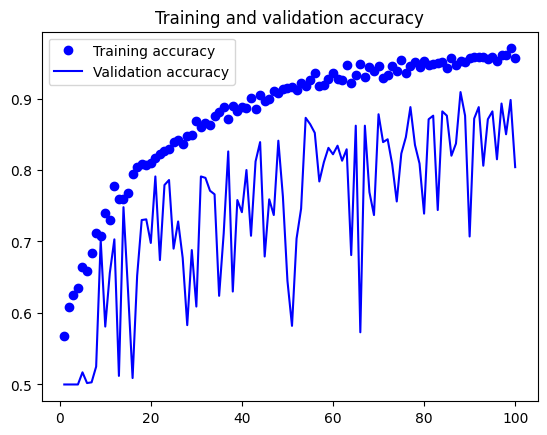

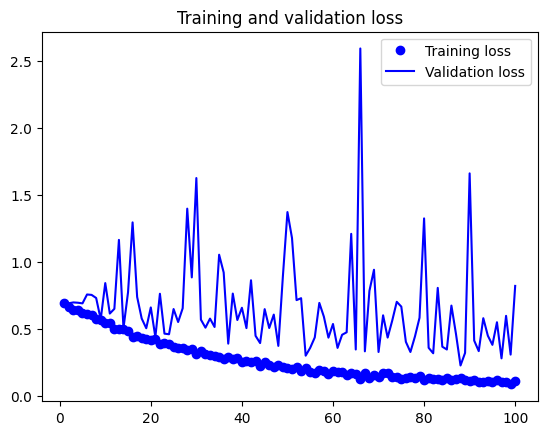

In [ ]:
# Display Training and validation metrics with an Xception-like architecture
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

The new model achieves the highest test accuracy of 90%,